In [8]:
import numpy as np
import pandas as pd
import scipy
from scipy import optimize
from scipy.optimize import minimize, linprog
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

'''  
Mean Variance
'''


'  \nMean Variance\n'

In [9]:
# read in data 
data = pd.read_csv('case2data.csv', index_col = 0)
train, test = train_test_split(data, test_size = 0.2, shuffle = False)

In [10]:
def MaximizeReturns(MeanReturns, PortfolioSize):
    
    c = (np.multiply(-1, MeanReturns))
    A = np.ones([PortfolioSize,1]).T
    b=[1]
    res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex') 
    
    return res

In [11]:
def MinimizeRisk(CovarReturns, PortfolioSize):
    
    def  f(x, CovarReturns):
        func = np.matmul(np.matmul(x, CovarReturns), x.T) 
        return func

    def constraintEq(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b 
        return constraintVal
    
    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq})
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = 10**-3)
    
    return opt

In [28]:
def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):
    
    def  f(x,CovarReturns):
         
        func = np.matmul(np.matmul(x,CovarReturns ), x.T)
        return func

    def constraintEq(x):
        AEq=np.ones(x.shape)
        bEq=1
        EqconstraintVal = np.matmul(AEq,x.T)-bEq 
        return EqconstraintVal
    
    def constraintIneq(x, MeanReturns, R):
        AIneq = np.array(MeanReturns)
        bIneq = R
        IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
        return IneqconstraintVal
    

    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq},
            {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
    lb = -1
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                        x0 = xinit,   bounds = bnds, constraints = cons, tol = 10**-3)
    
    return  opt

In [29]:
def StockReturnsComputing(StockPrice, Rows, Columns):
    
    StockReturn = np.zeros([Rows-1, Columns])
    for j in range(Columns):        # j: Assets
        for i in range(Rows-1):     # i: Daily Prices
            StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

    return StockReturn

In [41]:
# uniform weights
def calculateWeights(running_price_paths, running_weights_paths):
    
    portfolioSize = 6
    
    arStockPrices = np.asarray(running_price_paths)
    [Rows, Cols]=arStockPrices.shape
    arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)
    
    meanReturns = np.mean(arReturns, axis = 0)
    covReturns = np.cov(arReturns, rowvar=False)
    
    
    #Maximal expected portfolio return computation for the k-portfolio
    result1 = MaximizeReturns(meanReturns, portfolioSize)
    maxReturnWeights = result1.x
    maxExpPortfolioReturn = np.matmul(meanReturns.T, maxReturnWeights)
    #print("Maximal Expected Portfolio Return:   %7.4f" % maxExpPortfolioReturn )
    
    #expected portfolio return computation for the minimum risk k-portfolio 
    result2 = MinimizeRisk(covReturns, portfolioSize)
    minRiskWeights = result2.x
    minRiskExpPortfolioReturn = np.matmul(meanReturns.T, minRiskWeights)
    #print("Expected Return of Minimum Risk Portfolio:  %7.4f" % minRiskExpPortfolioReturn)
    
    increment = 0.001
    low = minRiskExpPortfolioReturn
    high = maxExpPortfolioReturn

    #initialize optimal weight set and risk-return point set
    xOptimal =[]
    minRiskPoint = []
    expPortfolioReturnPoint =[]

    #repeated execution of function MinimizeRiskConstr to determine the efficient set 
    #while (low < high):
        #result3 = MinimizeRiskConstr(meanReturns, covReturns, portfolioSize, low)
        #xOptimal.append(result3.x)
        #expPortfolioReturnPoint.append(low)
        #low = low+increment
        
    #gather optimal weight set    
    #xOptimalArray = np.array(xOptimal)
    
    
    
    return MinimizeRiskConstr(meanReturns, covReturns, portfolioSize, low).x

In [42]:
## given grading scheme
class Allocator():
    def __init__(self, train_data):
        '''
        Anything data you want to store between days must be stored in a class field
        '''
        self.running_price_paths = train_data.copy()
        self.train_data = train_data.copy()
        self.running_weights_paths = [[1/6, 1/6, 1/6, 1/6, 1/6, 1/6]]
        
        # Do any preprocessing here -- do not touch running_price_paths, it will store the price path up to that data
        
        
    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        ### edit: used np.append to make this work
        self.running_price_paths = np.append(self.running_price_paths, asset_prices)
    
        ### TODO Implement your code here
        #print(self.running_price_paths)
        
        historydays = 10
        
        paths1 = self.running_price_paths[-historydays * 6:].T
        pricePaths = []
        for i in range(historydays):
            sub = paths1[i*6: i*6+6]
            pricePaths.append(sub)
        pricePaths = np.array(pricePaths)
        #print(pricePaths)
        
            
        weights = calculateWeights(pricePaths, self.running_weights_paths)
        self.running_weights_paths.append(weights)
        
        return weights
    
    
def grading(train_data, test_data): 
    '''
    Grading Script
    '''
    weights = np.full(shape=(len(test_data.index),6), fill_value=0.0)
    alloc = Allocator(train_data)
    for i in range(0,len(test_data)):
        weights[i,:] = alloc.allocate_portfolio(test_data.iloc[i,:])
        if np.sum(weights < -1) or np.sum(weights > 1):
            raise Exception("Weights Outside of Bounds")
    
    capital = [1]
    for i in range(len(test_data) - 1):
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i,:])
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i,:]))
        net_change = np.dot(shares, np.array(test_data.iloc[i+1,:]))
        capital.append(balance + net_change)
    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]
    
    if np.std(returns) != 0:
        sharpe = np.mean(returns) / np.std(returns)
    else:
        sharpe = 0
        
    return sharpe, capital, weights

/var/folders/9j/_2xn1jdn2g97z_0bk9lqzm4m0000gn/T/ipykernel_48334/3898044632.py:6: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


0.07613488652967891


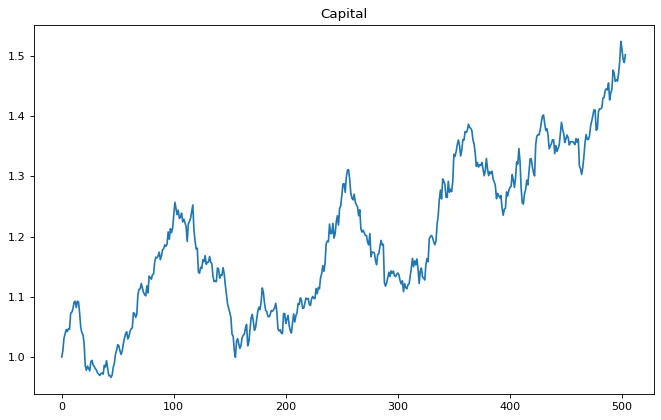

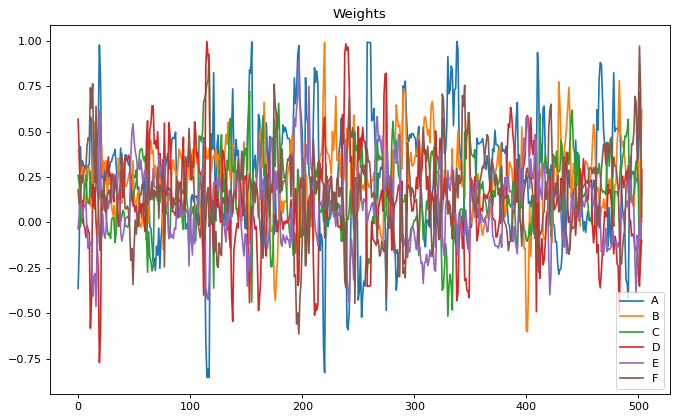

In [43]:
# run simulation
sharpe, capital, weights = grading(train, test)
print(sharpe)

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Capital")
plt.plot(np.arange(len(test)), capital)
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Weights")
plt.plot(np.arange(len(test)), weights)
plt.legend(test.columns)  
plt.show()